In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_1samp


# What's here? 
This notebook takes the participants most updates csv (with similarity scores) and plots analyses. mainly:
ground truth image to generated image similarity scores (clip + vgg)
ground image to description text scores (clip vis text alignment or vgg and sgpt rdm alignment, using the rdm df)

In [ ]:
# df for pilot analysis of real participants with stability ai model:
#currently df is the shuffled one
df = pd.read_csv("/mnt/hdd/anatkorol/Imagination_in_translation/Data/processed_data/08092025_pilot/participants_log_with_gpt_pilot_08092025_gpt-image-1_generation_with_distances_and_alignment_pilot_08092025.csv").copy() # "/mnt/hdd/anatkorol/Imagination_in_translation/Data/processed_data/08092025_pilot/participants_log_cleaned_pilot_08092025_shuffled_with_distances_and_alignment_pilot_08092025_.csv")
df = df[['uid', 'gt', 'session', 'attempt', 'prompt', 'gen', 'subjective_score','clip_cosine_distance', 'vgg_fc7_distance', 'clip_vis_text_similarity']].copy() # add 'prompt_word_len', 'token_num if needed
# return df_ppt and df_gpt when testing on other diffusion models
df_ppt = df[df['uid'] != 'gpt-5'].copy()
df_gpt = df[df['uid'] == 'gpt-5'].copy()
graphs_path = "/mnt/hdd/anatkorol/Imagination_in_translation/analysis/pilot_gpt-image-1/graphs/"
#rdm results for analysis
rdm_df = pd.read_csv("/mnt/hdd/anatkorol/Imagination_in_translation/Data/processed_data/08092025_pilot/rdm_alignment_results_gpt-image-1-generation_spearman_mean_pooling.csv") # I used mean pooling as it gives same weight to all tokens, maybe shoulod be changed - can play with it

In [13]:
df.head(3)

,uid,gt,session,attempt,img_index,request_seed,returned_seed,prompt,negative_prompt,subjective_score,...,model_latency_secs,rating_latency_secs,generated_at_utc,ts,gen,revised_prompt,clip_cosine_distance,vgg_fc7_distance,clip_vis_text_similarity,token_num
0,00aeccd632c742d48a9ffe94da201493,farm_h.jpg,1,1,1,481678699,481678699,Hall,NaN,13.0,...,11.655,13.221,2025-09-08T11:16:23.064779+00:00,1757330197,00aeccd632c742d48a9ffe94da201493_session01_attempt01_img01_gpt-image.png,NaN,0.397093,0.766330,0.243411,1
1,00aeccd632c742d48a9ffe94da201493,farm_h.jpg,1,2,1,481678699,481678699,Public meeting hall,NaN,64.0,...,12.852,14.576,2025-09-08T11:17:03.773220+00:00,1757330240,00aeccd632c742d48a9ffe94da201493_session01_attempt02_img01_gpt-image.png,NaN,0.548488,0.820993,0.245706,3
2,00aeccd632c742d48a9ffe94da201493,farm_h.jpg,1,3,1,481678699,481678699,Public bathroom,NaN,88.0,...,12.056,19.006,2025-09-08T11:17:49.615692+00:00,1757330290,00aeccd632c742d48a9ffe94da201493_session01_attempt03_img01_gpt-image.png,NaN,0.422836,0.810952,0.286268,2


In [18]:
print(df.columns)

Index(['uid', 'gt', 'session', 'attempt', 'prompt', 'gen', 'subjective_score',
       'clip_cosine_distance', 'vgg_fc7_distance', 'clip_vis_text_similarity'],
      dtype='object')


In [7]:
pd.set_option('display.max_colwidth', None)
df['token_num'].max()


np.int64(219)

In [27]:

# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Visualizing legnth of prompt by attempt

/tmp/ipykernel_20424/525857349.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_ppt_mean, x="attempt", y="prompt_word_len", ci="sd", color="lightblue")


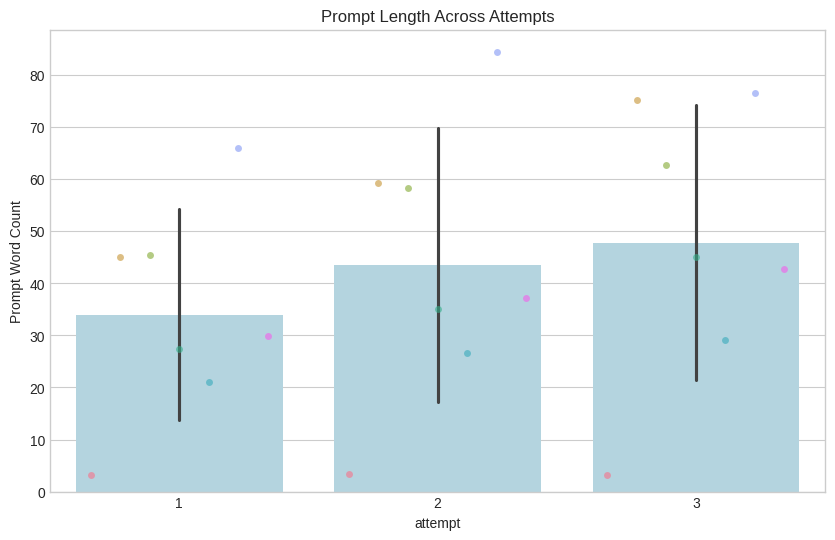

In [8]:
df_ppt_mean = df_ppt.groupby(["uid", "attempt"])["prompt_word_len"].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=df_ppt_mean, x="attempt", y="prompt_word_len", ci="sd", color="lightblue")
sns.stripplot(data=df_ppt_mean, x="attempt", y="prompt_word_len", hue="uid", alpha=0.6, jitter=True, dodge=True)
plt.ylabel("Prompt Word Count")
plt.title("Prompt Length Across Attempts")
plt.legend([],[], frameon=False)  #removing legend (info about ppt)
plt.show()

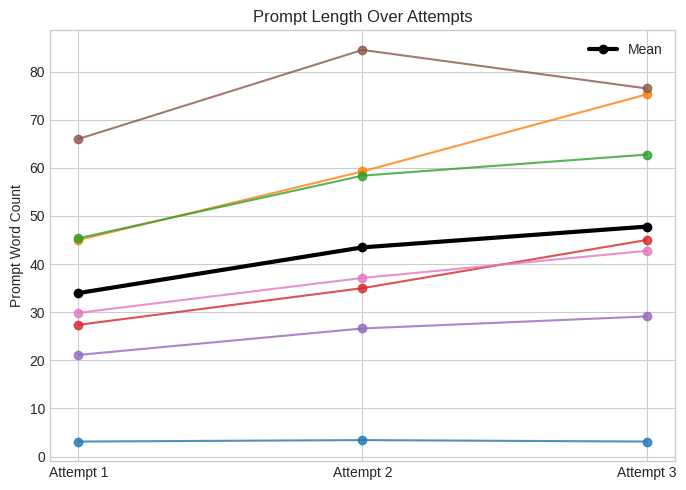

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df_ppt.groupby(["uid", "attempt"])["prompt_word_len"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="prompt_word_len")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("Prompt Word Count")
plt.title("Prompt Length Over Attempts")
plt.legend()
plt.tight_layout()
plt.show()


# Correlation between subjective and objective similarity scores 

In [28]:
# inverting cosine distance to similarity
df_ppt["clip_similarity"] = 1 - df_ppt["clip_cosine_distance"]
df_ppt['vgg_similarity'] = 1 - df_ppt['vgg_fc7_distance']
# df_gpt["clip_similarity"] = 1 - df_gpt["clip_cosine_distance"]
# df_gpt['vgg_similarity'] = 1 - df_gpt['vgg_fc7_distance']
df['clip_similarity'] = 1 - df['clip_cosine_distance']
df['vgg_similarity'] = 1 - df['vgg_fc7_distance']

## correlation between vgg and clip similarity

In [29]:
pearson_corr, pearson_p = pearsonr(df['clip_cosine_distance'], df['vgg_fc7_distance'])
print(f"Pearson correlation between CLIP and VGG distances: {pearson_corr:.3f} (p={pearson_p:.3f})")


Pearson correlation between CLIP and VGG distances: 0.340 (p=0.000)


## computing correlations between subjective and objective similarity scores - globally

In [30]:
#computing correlation as if all data points are independent - but they are not!!
pearson_corr, pearson_p = pearsonr(df_ppt["subjective_score"], df_ppt["clip_similarity"])
print(f"Pearson correlation between subjective score and CLIP similarity: {pearson_corr:.3f} (p={pearson_p:.3f})")

Pearson correlation between subjective score and CLIP similarity: -0.125 (p=0.108)


In [23]:
pearson_corr, pearson_p = pearsonr(df_ppt["subjective_score"], df_ppt["vgg_similarity"])
print(f"Pearson correlation between subjective score and VGG fc7 similarity: {pearson_corr:.3f} (p={pearson_p:.3f})")

Pearson correlation between subjective score and VGG fc7 similarity: -0.055 (p=0.480)


## computing correlations between subjective and objective similarity scores - within participants

/tmp/ipykernel_237187/128329713.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_corr, x="measure", y="r", ci=None, color="lightblue")


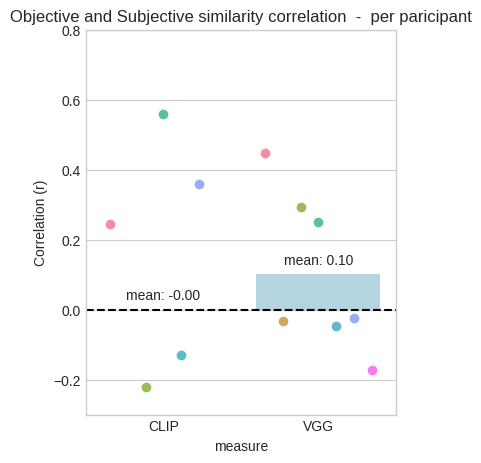

In [ ]:
# Collect correlations per participant
corrs = []
for uid, subdf in df_ppt.groupby("uid"):
    r_clip, _ = pearsonr(subdf["subjective_score"], subdf["clip_similarity"])
    r_vgg, _ = pearsonr(subdf["subjective_score"], subdf["vgg_similarity"])
    corrs.append({"uid": uid, "measure": "CLIP", "r": r_clip})
    corrs.append({"uid": uid, "measure": "VGG", "r": r_vgg})

df_corr = pd.DataFrame(corrs)

# Compute means
means = df_corr.groupby("measure")["r"].mean().reset_index()

plt.figure(figsize=(4,5))
ax = sns.barplot(data=df_corr, x="measure", y="r", ci=None, color="lightblue")

# Add participant dots
sns.stripplot(data=df_corr, x="measure", y="r", hue="uid",
              dodge=True, jitter=False, size=7, alpha=0.8)

# Add horizontal line at 0
plt.axhline(0, color="black", linestyle="--")

# Add mean value labels
for i, row in means.iterrows():
    ax.text(i, row["r"] + 0.02, f"mean: {row['r']:.2f}", 
            ha='center', va='bottom', fontsize=10)

plt.ylabel("Correlation (r)")
plt.title("Objective and Subjective similarity correlation  -  per paricipant")
plt.legend([],[], frameon=False)  # remove uid legend
plt.ylim(-0.3, 0.8)  # keep full r range visible
# plt.savefig(graphs_path + "per_participant_corr_subjective_with_objective_scores.png", dpi=300, bbox_inches="tight")
plt.show()


## measuring Mixed-effects regression 
* I don't understand it and I didn't report it for now*
* Treat subjective score as DV, and use clip/vgg similarity as predictors, with random intercepts for participants

In [100]:
import statsmodels.formula.api as smf

model = smf.mixedlm("subjective_score ~ vgg_similarity",
                    data=df_ppt, groups=df_ppt["uid"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: subjective_score
No. Observations: 167     Method:             REML            
No. Groups:       7       Scale:              300.5667        
Min. group size:  23      Log-Likelihood:     -718.3776       
Max. group size:  24      Converged:          Yes             
Mean group size:  23.9                                        
---------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        29.996     9.064  3.309  0.001  12.232  47.760
vgg_similarity   30.097     9.258  3.251  0.001  11.953  48.242
Group Var       384.118    13.455                              



In [101]:
import statsmodels.formula.api as smf

model = smf.mixedlm("subjective_score ~ clip_similarity",
                    data=df_ppt, groups=df_ppt["uid"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: subjective_score
No. Observations: 167     Method:             REML            
No. Groups:       7       Scale:              298.5118        
Min. group size:  23      Log-Likelihood:     -716.9690       
Max. group size:  24      Converged:          Yes             
Mean group size:  23.9                                        
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        -10.133   18.117 -0.559 0.576 -45.641  25.376
clip_similarity   74.080   21.602  3.429 0.001  31.742 116.419
Group Var        382.562   13.446                             



# similarity scores per attempt - ppt df and - only subjective scores

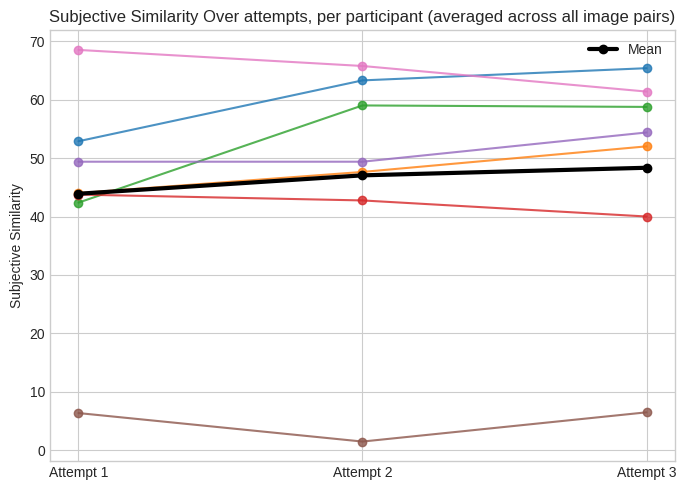

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df_ppt.groupby(["uid", "attempt"])["subjective_score"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="subjective_score")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("Subjective Similarity")
plt.title("Subjective Similarity Over attempts, per participant (averaged across all image pairs)")
plt.legend()
plt.tight_layout()
# plt.savefig(graphs_path + "subjective_similarity_over_attempts_per_participant.png", dpi=500, bbox_inches="tight")
plt.show()


## Now subjective similarity across images
maybe this can tell us if some images are harder then others and will consistly rsults in a generated image that is not very similar to the ground truth

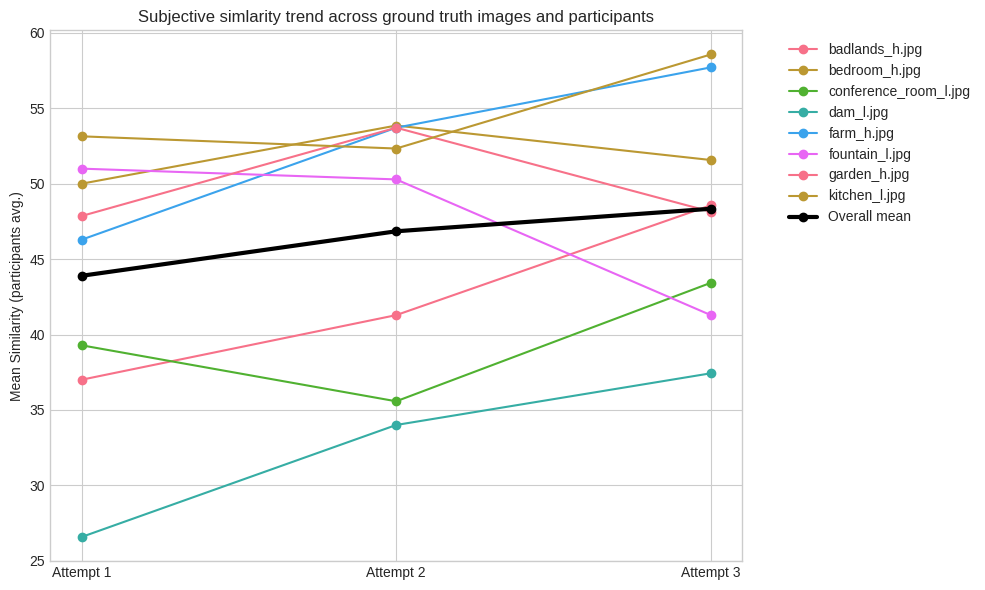

In [35]:
# 1) Mean subjective score per GT per attempt (averaging across participants)
df_gt = (
    df_ppt
    .groupby(["gt", "attempt"], as_index=False)["subjective_score"]
    .mean()
    .rename(columns={"subjective_score": "mean_score"})
)
plt.figure(figsize=(10,6))
for gt, sub in df_gt.groupby("gt"):
    plt.plot(sub["attempt"], sub["mean_score"], marker="o", lw=1.5, label=gt)

plt.plot(df_gt.groupby("attempt")["mean_score"].mean(), 
         marker="o", color="black", lw=3, label="Overall mean")

plt.xticks([1,2,3], ["Attempt 1","Attempt 2","Attempt 3"])
plt.ylabel("Mean Similarity (participants avg.)")
plt.title("Subjective simlarity trend across ground truth images and participants")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
# plt.savefig(graphs_path + "subjective_similarity_trend_across_gt_and_participants.png", dpi=500, bbox_inches="tight")
plt.show()

## similarity scores per attempt - objective scoreres - ppt and gpt df


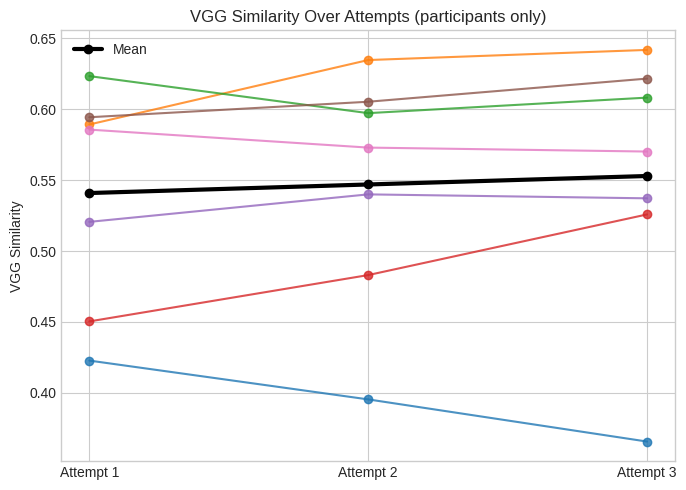

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df_ppt.groupby(["uid", "attempt"])["vgg_similarity"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="vgg_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("VGG Similarity")
plt.title("VGG Similarity Over Attempts (participants only)")
plt.legend()
plt.tight_layout()
plt.savefig(graphs_path + "vgg_similarity_over_attempts_per_participant.png", dpi=500, bbox_inches="tight")
plt.show()


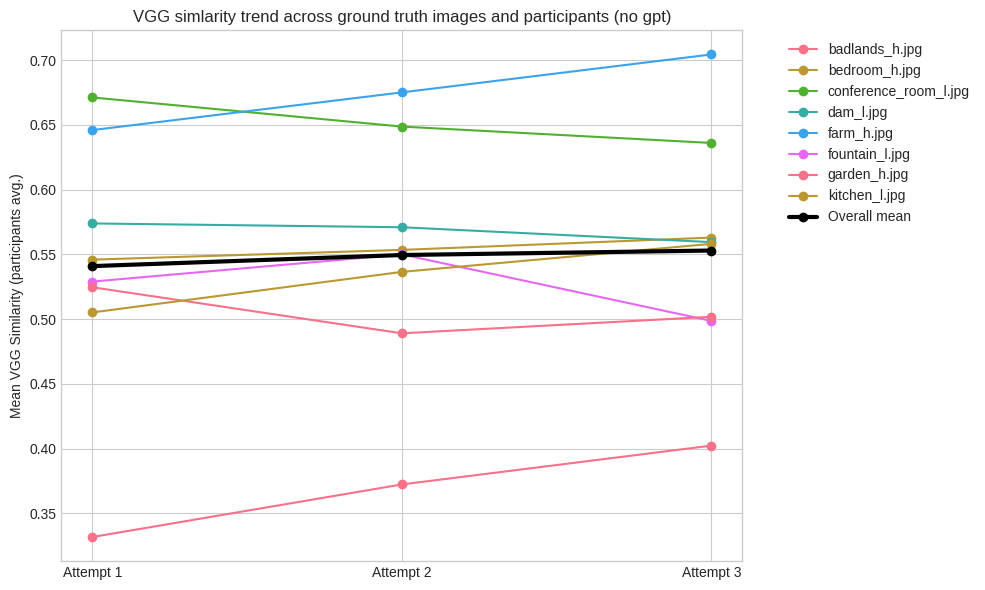

In [37]:
# 1) Mean subjective score per GT per attempt (averaging across participants)
df_gt = (
    df_ppt
    .groupby(["gt", "attempt"], as_index=False)["vgg_similarity"]
    .mean()
    .rename(columns={"vgg_similarity": "mean_score"})
)
plt.figure(figsize=(10,6))
for gt, sub in df_gt.groupby("gt"):
    plt.plot(sub["attempt"], sub["mean_score"], marker="o", lw=1.5, label=gt)

plt.plot(df_gt.groupby("attempt")["mean_score"].mean(), 
         marker="o", color="black", lw=3, label="Overall mean")

plt.xticks([1,2,3], ["Attempt 1","Attempt 2","Attempt 3"])
plt.ylabel("Mean VGG Similarity (participants avg.)")
plt.title("VGG simlarity trend across ground truth images and participants (no gpt)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(graphs_path + "vgg_similarity_trend_across_gt_and_participants.png", dpi=500, bbox_inches="tight")
plt.show()

## similarity scores per attemp - VGG and CLIP for participants and gpt - we can see gpt generated images produce a slightly higher similarity scores, but no trend of increased similarity as attempts progress

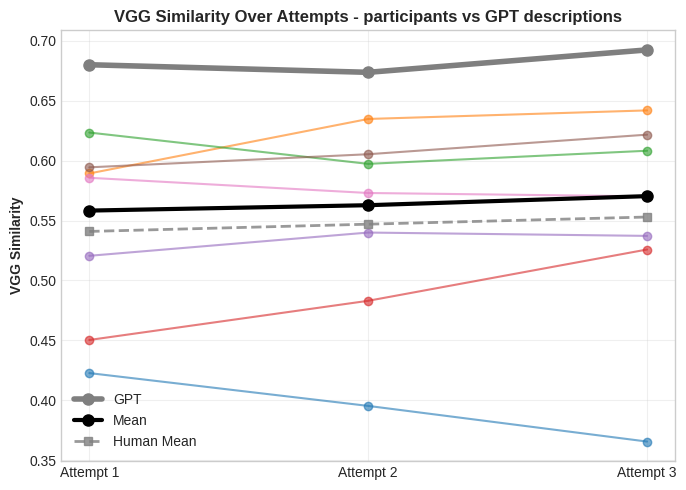

In [38]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df.groupby(["uid", "attempt"])["vgg_similarity"].mean().reset_index()

# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="vgg_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    if uid == 'gpt-5':  # Assuming GPT's uid is 'gpt' - adjust as needed
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", alpha=1.0, color=color, 
                 label="GPT", linewidth=4, markersize=8)
    else:
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", lw=1.5, alpha=0.6, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, 
         label="Mean", markersize=8)

# Add human average line (excluding GPT if needed)
human_data = wide[wide.index != 'gpt-5']  # Adjust GPT identifier as needed
human_mean = human_data.mean()
plt.plot([1,2,3], human_mean, marker="s", color="gray", linewidth=2, 
         linestyle="--", label="Human Mean", alpha=0.8, markersize=6)

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("VGG Similarity", fontweight='bold')
plt.title("VGG Similarity Over Attempts - participants vs GPT descriptions", fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.savefig(graphs_path + "vgg_similarity_over_attempts_participants_vs_gpt.png", dpi=500, bbox_inches="tight")
plt.tight_layout()
plt.show()

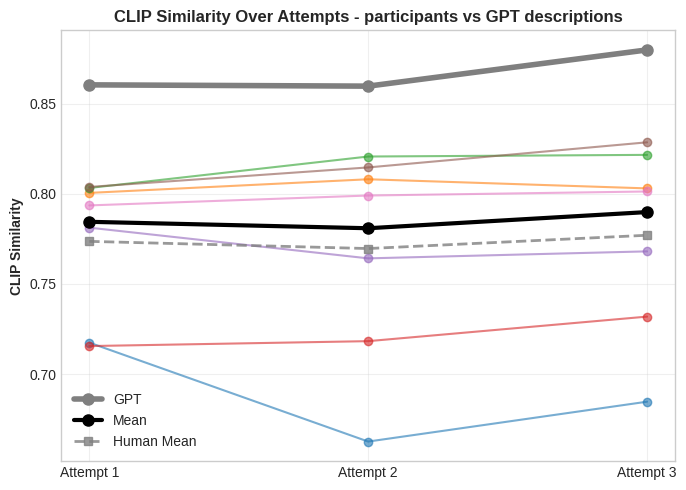

In [40]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df.groupby(["uid", "attempt"])["clip_similarity"].mean().reset_index()

# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="clip_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    if uid == 'gpt-5':  # Assuming GPT's uid is 'gpt' - adjust as needed
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", alpha=1.0, color=color, 
                 label="GPT", linewidth=4, markersize=8)
    else:
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", lw=1.5, alpha=0.6, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, 
         label="Mean", markersize=8)

# Add human average line (excluding GPT if needed)
human_data = wide[wide.index != 'gpt-5']  # Adjust GPT identifier as needed
human_mean = human_data.mean()
plt.plot([1,2,3], human_mean, marker="s", color="gray", linewidth=2, 
         linestyle="--", label="Human Mean", alpha=0.8, markersize=6)

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("CLIP Similarity", fontweight='bold')
plt.title("CLIP Similarity Over Attempts - participants vs GPT descriptions", fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.savefig(graphs_path + "clip_similarity_over_attempts_participants_vs_gpt.png", dpi=500, bbox_inches="tight")
plt.tight_layout()
plt.show()

# Comparing descriptions to gt images (without looking at gen images) - CLIP alignment between images and text (with 77 token limit)


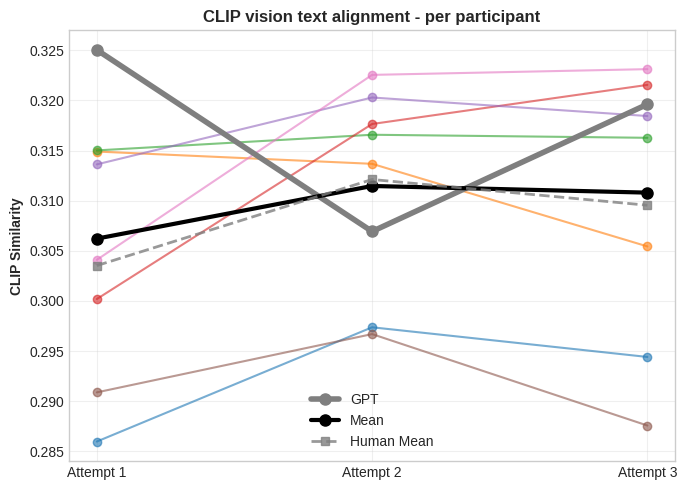

In [42]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
# df_new_ppt = df_new[df_new['uid'] != 'gpt-5'].copy()
df_mean = df.groupby(["uid", "attempt"])["clip_vis_text_similarity"].mean().reset_index()

# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="clip_vis_text_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    if uid == 'gpt-5':  # Assuming GPT's uid is 'gpt' - adjust as needed
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", alpha=1.0, color=color, 
                 label="GPT", linewidth=4, markersize=8)
    else:
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", lw=1.5, alpha=0.6, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, 
         label="Mean", markersize=8)

# Add human average line (excluding GPT if needed)
human_data = wide[wide.index != 'gpt-5']  # Adjust GPT identifier as needed
human_mean = human_data.mean()
plt.plot([1,2,3], human_mean, marker="s", color="gray", linewidth=2, 
         linestyle="--", label="Human Mean", alpha=0.8, markersize=6)

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("CLIP Similarity", fontweight='bold')
plt.title("CLIP vision text alignment - per participant", fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.savefig(graphs_path + "clip_vision_text_alignment_over_attempts_participants_vs_gpt.png", dpi=500, bbox_inches="tight")
plt.tight_layout()
plt.show()

# RDM plotting - are image text relations getting stronger over attempts?   

In [44]:
rdm_df.columns

Index(['uid', 'attempt', 'n_items', 'rdm_corr_spearman', 'rdm_corr_p'], dtype='object')

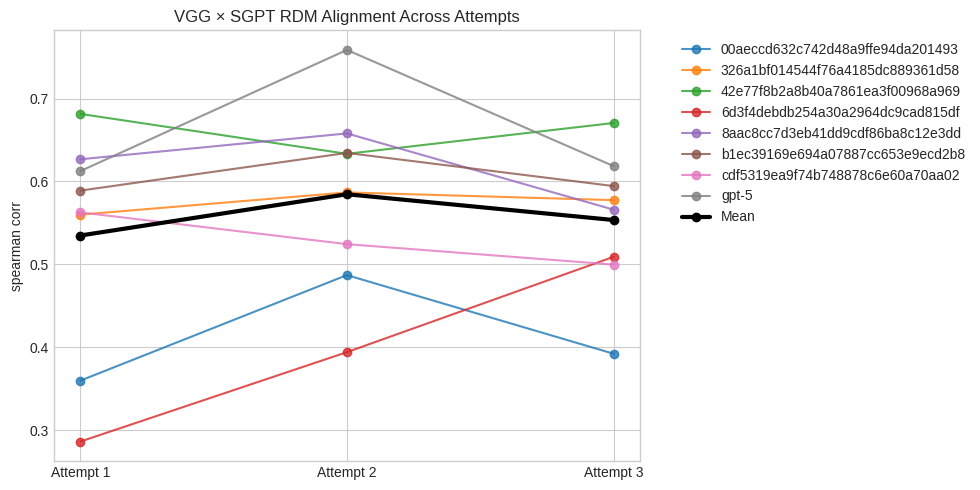

In [45]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = rdm_df.groupby(["uid", "attempt"])["rdm_corr_spearman"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="rdm_corr_spearman")

plt.figure(figsize=(10,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color, label=uid)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("spearman corr")
plt.title("VGG × SGPT RDM Alignment Across Attempts")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(graphs_path + "vgg_sgpt_rdm_alignment_over_attempts_per_participant.png", dpi=500, bbox_inches="tight")
plt.show()
